# Module 2 Final Project
**Name:** Emily Pfeifer

**Blog URL:** https://pfeiferem.weebly.com/northwind-database.html

**Instructor:** Brandon Lewis

## Getting Started

Below we will begin working on the SQL data for the fictional company "NorthWind". As their data scientist, it is our job to extract relevant information from the gathered data provided by NorthWind. We will be using a frequestist statistical approach to perform hypothesis tests on the data so that we can improve NorthWind's business model.

In [1]:
import sqlite3 #import necessary libraries
import pandas as pd #working with dataframes
import matplotlib.pyplot as plt #visualizations 
import seaborn as sns #visualizations
import numpy as np #math functions
from scipy import stats #statistical operations
import math #math functions
import scipy #statistical operations
#command to display graphs in our jupyter notebook

%matplotlib inline 

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite') #connect to database
c = conn.cursor() #set cursor

In [3]:
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall() #get list of tables in SQL data base
tables = [i[0] for i in tables]

In [4]:
tables #let's see what we have

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [5]:
#converting list of tables into pandas dataframes
dfs = [] #empty list to fill with our new dataframes
for i in tables: #creating a for loop to convert each table to a dataframe for further analysis
    table = c.execute('select * from "'+i+'"').fetchall() 
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    dbname = i+"_df" #this will create the database names
    exec(dbname + " = df") 
    dfs.append(dbname)

In [6]:
dfs #checking our work

['Employee_df',
 'Category_df',
 'Customer_df',
 'Shipper_df',
 'Supplier_df',
 'Order_df',
 'Product_df',
 'OrderDetail_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Region_df',
 'Territory_df',
 'EmployeeTerritory_df']

In [7]:
def preview_data(df, Heads = ['Description','Shape', 'Unique','Types']): #create function to get details on each table/dataframe
    preview_return = {'Description':df.describe(), 'Shape':df.shape, #returning description, shape
                     'Unique':df.nunique(axis = 0), 'Types':df.dtypes}  #number of unique values, and datatypes
    return preview_return  

## Q1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

Let's start this by performing some Exploratory Data Analysis.

In [8]:
preview_data(OrderDetail_df) #get some info on Order Details

{'Description':             OrderId    ProductId    UnitPrice     Quantity     Discount
 count   2155.000000  2155.000000  2155.000000  2155.000000  2155.000000
 mean   10659.375870    40.793039    26.218520    23.812993     0.056167
 std      241.378032    22.159019    29.827418    19.022047     0.083450
 min    10248.000000     1.000000     2.000000     1.000000     0.000000
 25%    10451.000000    22.000000    12.000000    10.000000     0.000000
 50%    10657.000000    41.000000    18.400000    20.000000     0.000000
 75%    10862.500000    60.000000    32.000000    30.000000     0.100000
 max    11077.000000    77.000000   263.500000   130.000000     0.250000,
 'Shape': (2155, 6),
 'Unique': Id           2155
 OrderId       830
 ProductId      77
 UnitPrice     116
 Quantity       55
 Discount       11
 dtype: int64,
 'Types': Id            object
 OrderId        int64
 ProductId      int64
 UnitPrice    float64
 Quantity       int64
 Discount     float64
 dtype: object}

Right off the bat, I just want to get a visualization on what our discounted product quantities vs. our non-discounted product quanitities look like.

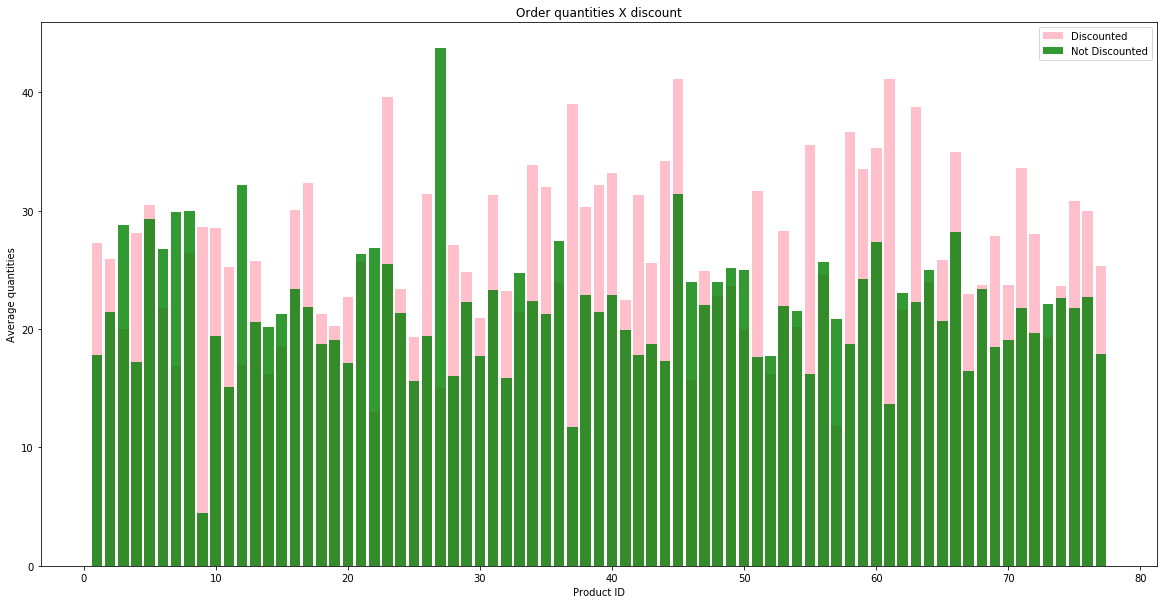

In [9]:
#grouping discounted products by average quantity sold and non-discounted products by average quantity sold
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(20,10)) #plotting these two new groups on the same bar graph for comparison
plt.bar(discount.index, discount.values, alpha=1, label='Discounted', color='pink')
plt.bar(no_discount.index, no_discount.values, alpha=0.8, label='Not Discounted', color='green') #stylistic choices
plt.legend()
plt.title('Order quantities X discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

It's clear that for some products, the discount created a spike in the average quantity ordered. To test if the difference is significant, we will run a hypothesis test on the data.

Northwind is not only curious about whether or not a discount impacts the number of products that a customer buys, but they want to know specifically how the level of discount ties in. With this in mind, I am going to take a closer look at the Discount variable.

In [10]:
OrderDetail_df.Discount.value_counts() #let's see the spread of value counts

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

It looks like discount levels .01, .02, .03, .04 and .06 are too small to really give us any information. Let's drop them from our dataset.

In [11]:
#Making a list of the discount levels that I want to keep
keep = (OrderDetail_df.Discount == 0.00) | (OrderDetail_df.Discount == 0.05) | (OrderDetail_df.Discount == 0.10) | (OrderDetail_df.Discount == 0.15) | (OrderDetail_df.Discount == 0.20) | (OrderDetail_df.Discount == 0.25)
data = OrderDetail_df.loc[keep] #creating a new df that only has those discount levels
data.Discount.value_counts() #checking our work

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

### Q1a: Do discounts have a statistically significant effect on the number of products customers order?

This brings us to our null and alternative hypothesises for Q1a. We will set the significance level at .05.

$H_0$: The discount level will not have an effect on the average quantity of products ordered ($H_0: \mu_1 = \mu_2 = \mu_3 =  ...  = \mu_i ...  = \mu_j$)

$H_a$: The discount level will have an effect on the average quantity of products ordered ($H_a: \mu_i \neq \mu_j$)

### Welch's T-Testing

We will be using Welch's T-Test, which is a "two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values" according to the function's documentation on scipy.org. Welch's T- Test is considered more conservative that the common Student's T-Test, meaning that the probability of erroneously rejecting the null hypothesis is not greater than the nominal level.

We will also be operating under the assumptions that our data is independent, collected randomly, and approximately normally distributed.

Because we did not collect the data ourselves, all we can do is assume that the data is independent and collected randomly. The only thing that we can test for at this point is that the data is normally disributed. We will test this using an Anderson-Darling test.

In [12]:
nondiscount = data[data['Discount']==0]['Quantity'] #setting our control variable to quanities where there was no discount
discount = data[data['Discount']!=0]['Quantity'] #setting our experimental variable to quantities where there was a discount

In [13]:
#let's run an anderson-darling test using scipy's built in feature
from scipy.stats import anderson
result_nd = anderson(nondiscount) #running A-D test for non-discounted products
result_d = anderson(discount) #running A-D test for discounted products
print("Control Results:", result_nd)
print("\nExperimental Results:", result_d)

Control Results: AndersonResult(statistic=44.59835234133561, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Experimental Results: AndersonResult(statistic=27.85064706894036, critical_values=array([0.573, 0.653, 0.783, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Anderson-Darling tests the null hypothesis that our data is not normally distributed. The output we recieve from our test is the test-statistic and an array of critical values as well as an array of corresponding significance levels. We can interpret that both our control data and our experimental data are normally distributed based on the fact that the test statistics are larger than our critical values, meaning that we can reject the null.

In [14]:
data.Discount.describe() #descriptive statistics of our Discount column

count    2147.000000
mean        0.056265
std         0.083586
min         0.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         0.250000
Name: Discount, dtype: float64

We need a little bit of information before we continue. Specifically, we need to figure out the critical T-value.

Looks like our data consists of 2147 observations, so n = 2147. Let's keep in mind that most of the orders are not discounted. 

For our Welch's t-test, we need to calculate the degrees of freedom, which is equal to n-1, so df = 2146.

As previously stated, we are setting alpha (the significance level) to .05.

In [15]:
#this formula for scipy lets us just plug in alpha and our degrees of freedom
#and then it returns the critical t-value
scipy.stats.t.ppf(1-.05, 2146)

1.6455639862952895

In [16]:
#let's start defining our relevant statistics
t_val_crit = 1.646 #setting our t-value
control_mean = nondiscount.mean() #setting our control mean
experimental_mean = discount.mean() #setting our experimental mean
mean_diff = (experimental_mean - control_mean) #retrieve the difference between the two
sigma = np.sqrt(((len(nondiscount)*(nondiscount.var())) + (len(discount)*(discount.var())))/((len(nondiscount))+(len(discount))))

In [17]:
results = stats.ttest_ind(nondiscount, discount) #running our Welch's T-Test
print ("t-value =", abs(round(results[0], 2)), "and the p-value =", np.round((results[1]), 10)) #printing results

t-value = 6.76 and the p-value = 0.0


As we can see, the t-value is higher than our critical t-value and our p-value is less that .05, meaning that we can reject the null hypothesis. This means that there is a statistically significant difference between the average quantities of products ordered with no discount and the average quantities of products ordered with discounts!

Now let's take a look at the effect size using Cohen's D.

### Cohen's D and Effect Size

In [18]:
#cohen's d is calculated by taking the difference of the means and dividing them by the standard variation
#we have done most of the legwork by hand up above
cd = mean_diff/sigma #formula for cohen's d statistic
abs(cd) #taking the absolute value of our result

0.29970787209408895

It looks like Cohen's D Statistic is equal to about .3, which is on the smaller side, but could still be considered a medium effect size. Effect size is important because it lets us quickly see how much a difference "matters", without actually needing to compare any specific numbers.

### Q1b: Is there a difference between the effects of discount devels?

$H_0$: There is no difference in the means of order quantity across the discount levels.

$H_a$: There is a difference in the means of order quantity across the discount levels.

To see if the level of discount has an effect on order quantity, I will be using a one-way Anova (analysis of variance) test, which is used to compare two means from two independent (unrelated) groups using the F-distribution. I will then run a Tukey HSD test, which will report the data from our Anova test and let us know if we are able to reject our null hypothesis or not. 

In [19]:
import statsmodels.api as sm #import necessary libraries
from statsmodels.formula.api import ols

#I will begin with an OLS regression, from which we can get the ANOVA
formula = 'Quantity ~ Discount' #defining our formula
lm = ols(formula, data).fit() #fitting the model
print(lm.summary())
table = sm.stats.anova_lm(lm, typ=2) #retrieving f-values and p-values
print(table)

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     35.49
Date:                Fri, 01 Nov 2019   Prob (F-statistic):           2.99e-09
Time:                        13:19:41   Log-Likelihood:                -9351.1
No. Observations:                2147   AIC:                         1.871e+04
Df Residuals:                    2145   BIC:                         1.872e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2628      0.491     45.374      0.0

From the table above, we can see that the F-Statistic has a value of 35.49 and a p-value less than .05, which confirms our findings from before that there is a statistically significant difference between order quantities of dicounted and non-discounted items.

To clearly see the difference of effect across discount levels, we will be using a Tukey HSD test, which like Welch's T-Test, is considered conservative.

In [20]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, #using statsmodels built-in tukey test
                                         MultiComparison)

mod = MultiComparison(data['Quantity'], data['Discount']) #defining the formula and running the Tukey test
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   6.2955  0.001  2.0814 10.5097   True
   0.0    0.1   3.5217 0.1885 -0.8187  7.8622  False
   0.0   0.15   6.6669  0.001  2.1352 11.1986   True
   0.0    0.2   5.3096 0.0096  0.8285  9.7907   True
   0.0   0.25    6.525  0.001   1.954  11.096   True
  0.05    0.1  -2.7738  0.704 -8.4504  2.9028  False
  0.05   0.15   0.3714    0.9 -5.4528  6.1955  False
  0.05    0.2   -0.986    0.9 -6.7708  4.7989  False
  0.05   0.25   0.2294    0.9 -5.6253  6.0842  False
   0.1   0.15   3.1452 0.6333  -2.771  9.0613  False
   0.1    0.2   1.7879    0.9 -4.0896  7.6653  False
   0.1   0.25   3.0033  0.677  -2.943  8.9496  False
  0.15    0.2  -1.3573    0.9 -7.3775  4.6628  False
  0.15   0.25  -0.1419    0.9 -6.2292  5.9454  False
   0.2   0.25   1.2154    0.9 -4.8343  7.2652  False
----------------------------------------------

Out of all 15 comparisons that ran, it looks like only four comparisons give us cause to reject the null, and those four comparisons all involve our control, which is the discount level of 0. The table shows that we are unable to reject the null hypothesis between any of the discount levels, meaniing that there is no statistically significant difference between the means of product quantity across discount levels. 

## Q2: Will there be an effect on sales if Customers are from the same region as the Employees that selling to them?

I wonder if customers will be more willing to buy products or spend money when they are located in the same region as the employee helping them. I got this idea from the notion that sometimes people connect better with someone they have something in common with. It's possible that sharing a location with a customer may help an employee establish rapport.

I will be combining 4 tables into the same dataframe: Employee, Customer, Order, and OrderDetail. I will be taking the Region column from both the Customer and Employee tables and I will be taking the UnitPrice and Quantity columns from OrderDetail. I will use the Orders table to join them based on their primary keys.

In [21]:
#creating separate dataframe for Q2
#first I will select the data I want from each table
#then I will join the tables using the common ID
data_Q2 = pd.read_sql_query('''

                                
                                SELECT O.EmployeeId, O.CustomerId, O.Id AS Order_Id, E.Region AS Employee_Region, C.Region AS Customer_Region, OD.Quantity, OD.UnitPrice
                                FROM [Order] AS O 
                                JOIN Employee AS E
                                ON O.EmployeeId = E.Id
                                JOIN Customer AS C
                                ON O.CustomerId = C.Id
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                
                                ''', conn)

data_Q2.head()

,EmployeeId,CustomerId,Order_Id,Employee_Region,Customer_Region,Quantity,UnitPrice
0,5,VINET,10248,British Isles,Western Europe,12,14.0
1,5,VINET,10248,British Isles,Western Europe,10,9.8
2,5,VINET,10248,British Isles,Western Europe,5,34.8
3,6,TOMSP,10249,British Isles,Western Europe,9,18.6
4,6,TOMSP,10249,British Isles,Western Europe,40,42.4


I'm going to create a new column that I will call 'same_region' to show whether the customer and the employee are located in the same region.

In [22]:
#creating new columns based on whether the values for employee region and customer region are the same 
#if they are the same, the value will be the region that both party's share, if they are different, the value will be 'diff'
data_Q2['same_region'] = np.where((data_Q2['Employee_Region'] == data_Q2['Customer_Region']),
                                  'same', 'diff')

In [23]:
data_Q2.head(5) #previewing the data

,EmployeeId,CustomerId,Order_Id,Employee_Region,Customer_Region,Quantity,UnitPrice,same_region
0,5,VINET,10248,British Isles,Western Europe,12,14.0,diff
1,5,VINET,10248,British Isles,Western Europe,10,9.8,diff
2,5,VINET,10248,British Isles,Western Europe,5,34.8,diff
3,6,TOMSP,10249,British Isles,Western Europe,9,18.6,diff
4,6,TOMSP,10249,British Isles,Western Europe,40,42.4,diff


There are two ways that I would like to measure the effect that a common region can have - the first way is average order quantity and the second way is average order value.

In [24]:
#grouping the data by same_region X average order quantity
same_r_quantity = data_Q2[data_Q2['same_region'] != 'diff'].groupby('Order_Id')['Quantity'].mean()
diff_r_quantity = data_Q2[data_Q2['same_region'] == 'diff'].groupby('Order_Id')['Quantity'].mean()

In [25]:
#grouping the data by same_region X average order price
same_r_price = data_Q2[data_Q2['same_region'] != 'diff'].groupby('Order_Id')['UnitPrice'].mean()
diff_r_price = data_Q2[data_Q2['same_region'] == 'diff'].groupby('Order_Id')['UnitPrice'].mean()

Before we run our test, let's quickly scan for outliers in our data.

{'bodies': [<matplotlib.collections.PolyCollection at 0x2af4f583400>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2af4e9441d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2af4f583828>,
 'cbars': <matplotlib.collections.LineCollection at 0x2af4f583a90>}

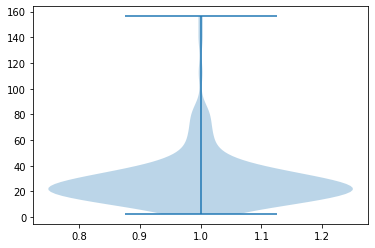

In [26]:
fig, axes = plt.subplots() #creating a violinplot
axes.violinplot(same_r_price)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2af4f5de470>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2af4f5ce1d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2af4f6020f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x2af4f602358>}

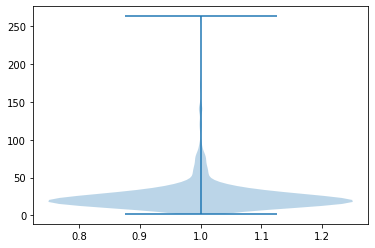

In [27]:
fig, axes = plt.subplots() #creating a violinplot
axes.violinplot(diff_r_price)

In [28]:
diff_r_price.describe() #let's take a closer look

count    661.000000
mean      25.697318
std       20.940011
min        2.000000
25%       15.350000
50%       20.933333
75%       28.500000
max      263.500000
Name: UnitPrice, dtype: float64

It looks like our diff_r_price is a bit more spread out than our same_r_price. Let's remove the max value (263) so that our data is a little bit more normal.

In [29]:
data_Q2 = data_Q2[data_Q2.UnitPrice != 263.5] #dropping 263.5 from our dataframe

Let's compare summary statistics for our new columns and see if we spot any trends right off the bat.

In [30]:
print("Same Region Price Stats:\n\n", same_r_price.describe()) #obtaining summary stats
print("\nDifferent Region Price Stats:\n\n",diff_r_price.describe())

Same Region Price Stats:

 count    140.000000
mean      29.540612
std       22.322176
min        2.500000
25%       16.595833
50%       23.862500
75%       32.540000
max      156.400000
Name: UnitPrice, dtype: float64

Different Region Price Stats:

 count    661.000000
mean      25.697318
std       20.940011
min        2.000000
25%       15.350000
50%       20.933333
75%       28.500000
max      263.500000
Name: UnitPrice, dtype: float64


In [31]:
print("Same Region Quantity Stats:\n\n", same_r_quantity.describe()) #obtaining summary stats
print("\nDifferent Region Quantity Stats:\n\n", diff_r_quantity.describe())

Same Region Quantity Stats:

 count    140.000000
mean      24.983548
std       14.476155
min        2.000000
25%       14.125000
50%       24.000000
75%       34.150000
max       75.000000
Name: Quantity, dtype: float64

Different Region Quantity Stats:

 count    661.000000
mean      22.538427
std       14.281011
min        1.000000
25%       12.666667
50%       20.000000
75%       28.333333
max       86.500000
Name: Quantity, dtype: float64


So far, it looks like customers from the same region as their corresponding employees have a slightly higher average value for their orders as well as a slightly higher quantity for their orders. Let's go ahead and run our one-way ANOVA test to see if the difference is actually statistically significant. 

### Q2a: If a customer and the employee responsible for their order are from the same region, will the customer spend more money on their order?

$H_0$: There is no difference in the average monetary value for orders made by customer's who live in the same region as the employee who helps them.

$H_a$: There is a difference in the average monetary value for orders made by customer's who live in the same region as the employee who helps them.

In [32]:
#once again running our ANOVA test
formula = 'UnitPrice ~ C(same_region)' #defining our formula
lm = ols(formula, data_Q2).fit() #fitting the model
print(lm.summary())
table = sm.stats.anova_lm(lm, typ=2) #retrieving f-values and p-values
print(table)

                            OLS Regression Results                            
Dep. Variable:              UnitPrice   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.441
Date:                Fri, 01 Nov 2019   Prob (F-statistic):             0.0352
Time:                        13:19:42   Log-Likelihood:                -9254.4
No. Observations:                2062   AIC:                         1.851e+04
Df Residuals:                    2060   BIC:                         1.852e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23

In [33]:
mod = MultiComparison(data_Q2['UnitPrice'], data_Q2['same_region']) #defining the formula and running the Tukey test
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  diff   same   2.5568 0.0352 0.1774 4.9362   True
--------------------------------------------------


According to our Tukey test, we can reject our null hypothesis. It looks like customers will have have higher average values on their orders if the employee who is helping them is from the same region as they are.

### Q2b: If a customer and the employee who helps them are from the same region, will they have a higher average quantity for their order?

$H_0$: There is no difference in the average quantity of orders made by customer's who live in the same region as the employee who helps them.

$H_a$: There is a difference in the average quantity of orders made by customer's who live in the same region as the employee who helps them.

In [34]:
#once again running our ANOVA test
formula = 'Quantity ~ C(same_region)' #defining our formula
lm = ols(formula, data_Q2).fit() #fitting the model
print(lm.summary())
table = sm.stats.anova_lm(lm, typ=2) #retrieving f-values and p-values
print(table)

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.203
Date:                Fri, 01 Nov 2019   Prob (F-statistic):              0.273
Time:                        13:19:42   Log-Likelihood:                -9013.4
No. Observations:                2062   AIC:                         1.803e+04
Df Residuals:                    2060   BIC:                         1.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23

In [35]:
mod = MultiComparison(data_Q2['Quantity'], data_Q2['same_region']) #defining the formula and running the Tukey test
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  diff   same   1.1838 0.2729 -0.9331 3.3008  False
---------------------------------------------------


According to the results of the Tukey test report that we fail to reject the null. While there is a statistically significant effect on common region and average order value, there is no significant effect between common region and average quantity of an order.

## Q3: Will products that reference a "Chef" in their name sell better than the products that do not reference Chefs in their title?

As I was exploring the data in the Product dataframe, I was curious about the creativity in the Product Name category. I noticed that a decent portion of the product names included the name of a "Chef", such as 'Sir Rodney's Scones' or 'Gnocchi di Nonna Alice'. I am curious if this establishs ethos or credibility with the target customer and thus increases sales of said product. I know that the name of a product is an important part of marketing, so I wonder if a "chef-inspired" product will encourage the consumer to buy more of said product or spend more on said product.



To explore this idea, I created a new dataframe by joining the Product table and the Order Detail table.

In [36]:
#creating separate dataframe for Q3
#first I will select the data I want from each table
#then I will join the tables using the common ID
data_Q3 = pd.read_sql_query('''

                                
                                SELECT P.Id, P.ProductName, OD.Quantity, OD.UnitPrice
                                FROM PRODUCT AS P 
                                JOIN OrderDetail AS OD
                                ON P.Id = ProductId
                                
                                ''', conn)

data_Q3.head() #let's check our work

,Id,ProductName,Quantity,UnitPrice
0,11,Queso Cabrales,12,14.0
1,42,Singaporean Hokkien Fried Mee,10,9.8
2,72,Mozzarella di Giovanni,5,34.8
3,14,Tofu,9,18.6
4,51,Manjimup Dried Apples,40,42.4


There were 77 unique product names (listed below). To separate the chef-inspired products to those that were not, I went through and made a list of the product names referencing Chefs. Many of the product names were not in English, so I made use of google to help distinguish whether the names were referencing chefs or not.

In [37]:
data_Q3.ProductName.unique() #list of unique product names for reference

array(['Queso Cabrales', 'Singaporean Hokkien Fried Mee',
       'Mozzarella di Giovanni', 'Tofu', 'Manjimup Dried Apples',
       "Jack's New England Clam Chowder",
       'Louisiana Fiery Hot Pepper Sauce', "Gustaf's Knäckebröd",
       'Ravioli Angelo', "Sir Rodney's Marmalade", 'Geitost',
       'Camembert Pierrot', 'Gorgonzola Telino', 'Chartreuse verte',
       'Maxilaku', 'Guaraná Fantástica', 'Pâté chinois', 'Longlife Tofu',
       'Chang', 'Pavlova', 'Inlagd Sill', 'Raclette Courdavault',
       'Perth Pasties', 'Original Frankfurter grüne Soße',
       'Schoggi Schokolade', "Chef Anton's Gumbo Mix",
       'Mascarpone Fabioli', "Sir Rodney's Scones", 'Gravad lax',
       'Tarte au sucre', 'Outback Lager', 'Steeleye Stout',
       "Uncle Bob's Organic Dried Pears", 'Gnocchi di nonna Alice',
       'Nord-Ost Matjeshering', 'Alice Mutton',
       'Queso Manchego La Pastora', 'Boston Crab Meat', 'Lakkalikööri',
       'Thüringer Rostbratwurst', 'Ipoh Coffee', 'Ikura', 'Flotemysos

In [38]:
#creating a new column in our dataframe based on whether or not the product name includes a chef
data_Q3['includes_chef'] = np.where((data_Q3['ProductName'] == "Chef Anton's Cajun Seasoning") | (data_Q3['ProductName'] == "Chef Anton's Gumbo Mix") | (data_Q3['ProductName'] == "Grandma's Boysenberry Spread") |
(data_Q3['ProductName'] == "Uncle Bob's Organic Dried Pears") | (data_Q3['ProductName'] == "Sir Rodney's Marmalade") | (data_Q3['ProductName'] == "Sir Rodney's Scones") |
(data_Q3['ProductName'] == "Gustaf's Knäckebröd") | (data_Q3['ProductName'] == 'Gumbär Gummibärchen') | (data_Q3['ProductName'] == "Jack's New England Clam Chowder")|
(data_Q3['ProductName'] == 'Gnocchi di nonna Alice') | (data_Q3['ProductName'] == 'Mozzarella di Giovanni'), 'yes', 'no')

data_Q3.head()

,Id,ProductName,Quantity,UnitPrice,includes_chef
0,11,Queso Cabrales,12,14.0,no
1,42,Singaporean Hokkien Fried Mee,10,9.8,no
2,72,Mozzarella di Giovanni,5,34.8,yes
3,14,Tofu,9,18.6,no
4,51,Manjimup Dried Apples,40,42.4,no


Now to continue with some Exploratory Data Analysis, let's go ahead and group our chef and non-chef data by average quantity. I will then take distribution plots of our two new data groupings to compare the shape and check normality.

In [39]:
chef_quantity = data_Q3[data_Q3['includes_chef'] == 'yes'].groupby('ProductName')['Quantity'].mean()
no_chef_quantity = data_Q3[data_Q3['includes_chef'] == 'no'].groupby('ProductName')['Quantity'].mean()

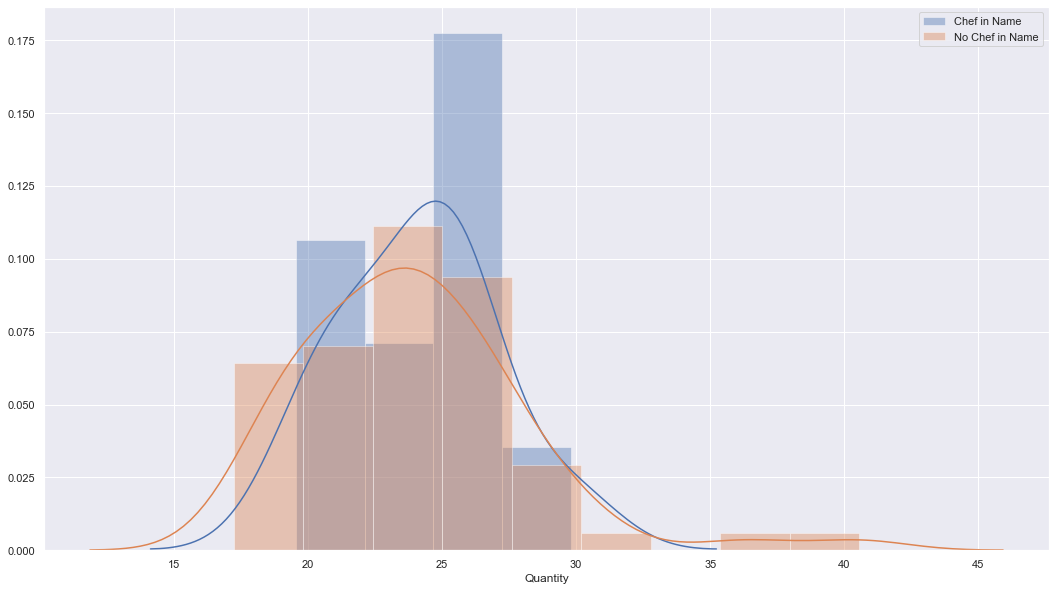

In [40]:
sns.set(color_codes=True) #creating our dist plots
sns.set(rc={'figure.figsize':(18, 10)})
sns.distplot(chef_quantity, label='Chef in Name'); # Blue distribution for chef data
sns.distplot(no_chef_quantity, label='No Chef in Name'); # Green distribution for non-chef data
plt.legend()
plt.show();

It looks like our data is fairly normal! I do see that the chef data is slightly multi-modal and that the right tail of our non-chef data is a little spread out, but I am mostly satisfied with these distributions. I can also see that my hunch might be correct, it does look like our chef products might sell in higher quantities! Let's look at some numbers to investigate this further.

In [41]:
print("Chef Name Largest:")
chef_quantity.nlargest(5) #I'm curious about the top five highest values in my chef data

Chef Name Largest:


ProductName
Chef Anton's Gumbo Mix             29.800000
Uncle Bob's Organic Dried Pears    26.310345
Sir Rodney's Scones                26.051282
Gnocchi di nonna Alice             25.260000
Grandma's Boysenberry Spread       25.083333
Name: Quantity, dtype: float64

In [42]:
print("No Chef Name Largest:") 
no_chef_quantity.nlargest(5) #how about top five highest value for no_chef

No Chef Name Largest:


ProductName
Schoggi Schokolade           40.555556
Rogede sild                  36.285714
Camembert Pierrot            30.921569
Louisiana Hot Spiced Okra    29.875000
Escargots de Bourgogne       29.666667
Name: Quantity, dtype: float64

Looking at these numbers, it looks like the top values in no_chef are much higher than in chef. This might also be because we have a lot more data in our no_chef category, as only 11 out of the 77 product names referenced chef names. In general, as the amount of data in a category grows, so does the range of values. Let's continue with EDA for our unitprice and includes_chef variables.

In [43]:
#grouping our data by chef/no-chef and price per product
chef_price = data_Q3[data_Q3['includes_chef'] == 'yes'].groupby('ProductName')['UnitPrice'].mean()
no_chef_price= data_Q3[data_Q3['includes_chef'] == 'no'].groupby('ProductName')['UnitPrice'].mean()

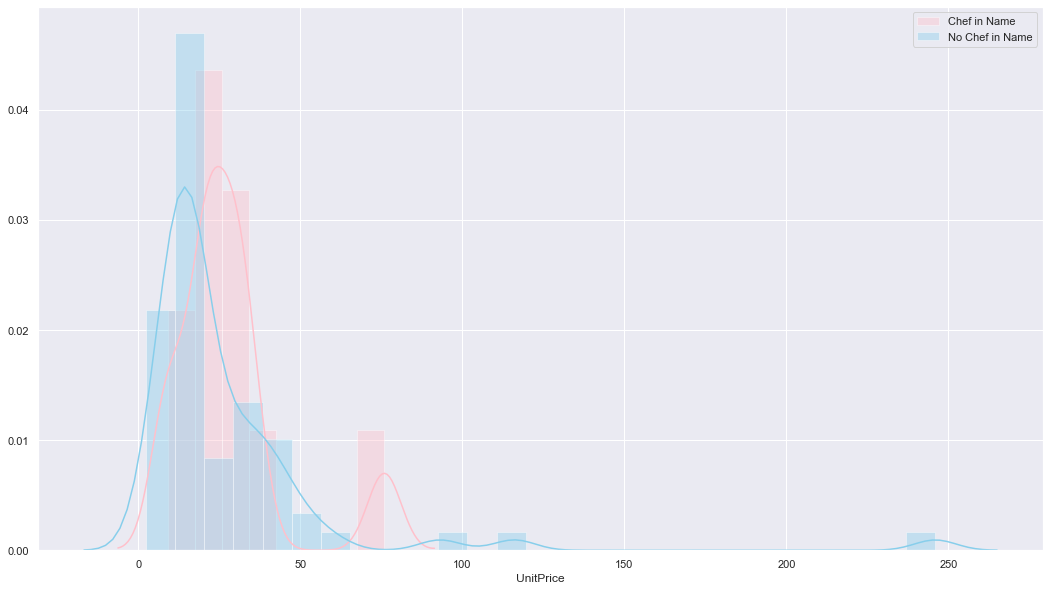

In [44]:
sns.set(color_codes=True) #creating our histograms
sns.set(rc={'figure.figsize':(18, 10)})
sns.distplot(chef_price, label='Chef in Name', color = 'pink'); # PINK distribution for chef data (different from Quantity distplots)
sns.distplot(no_chef_price, label='No Chef in Name', color = 'skyblue'); # SKY-BLUE distribution for non-chef data
plt.legend()
plt.show();

Once again, because we have a lot more data in our non-chef group, the distribution is much more spread out. However, it does look like both groups are relatively normal. Let's remove our products that are in the 200.00 dollar range like we did in our common-region data to normalize our data and give our chef group a fighting chance. I think this will also be important to analyzing our chef vs. quantity data, because people will probably buy much smaller quantities of products that are over 200.00 compared to the products that roughly 100.00 dollars cheaper.

In [45]:
a = data_Q3.UnitPrice.unique() #closer look at our spread of data in our price column
print (sorted(a))

[2.0, 2.5, 3.6, 4.5, 4.8, 5.6, 5.9, 6.0, 6.2, 7.0, 7.2, 7.3, 7.45, 7.6, 7.7, 7.75, 8.0, 9.0, 9.2, 9.5, 9.6, 9.65, 9.8, 10.0, 10.2, 10.4, 10.6, 11.2, 12.0, 12.4, 12.5, 12.75, 13.0, 13.25, 13.6, 13.9, 14.0, 14.4, 14.7, 15.0, 15.2, 15.5, 15.6, 16.0, 16.25, 16.8, 17.0, 17.2, 17.45, 17.6, 18.0, 18.4, 18.6, 19.0, 19.2, 19.45, 19.5, 20.0, 20.7, 20.8, 21.0, 21.05, 21.35, 21.5, 22.0, 22.8, 23.25, 24.0, 24.8, 24.9, 25.0, 25.6, 25.89, 26.0, 26.2, 26.6, 27.2, 27.8, 28.5, 28.8, 30.0, 30.4, 31.0, 31.2, 31.23, 32.0, 32.8, 33.25, 34.0, 34.8, 35.1, 36.0, 36.4, 36.8, 38.0, 39.0, 39.4, 40.0, 42.4, 43.9, 44.0, 45.6, 46.0, 49.3, 50.0, 53.0, 55.0, 62.5, 64.8, 77.6, 81.0, 97.0, 99.0, 123.79, 210.8, 263.5]


In [46]:
#there are only 2 products that are over 200.00, and the third highest priced-product is only $123.00
data_Q3 = data_Q3[data_Q3.UnitPrice < 210 ] #removing products that cost more than $200.00

Let's move on to running our hypothesis tests. Once again, we will be using a One-Way ANOVA.

### Q3a: Will products that reference a "Chef" in their name sell in larger quantities on average than the products that do not reference Chefs in their name?

$H_0$: There is no difference in the averge quantity sold of products that reference a chef in their name versus products that do not reference chefs in their name.

$H_a$: There is a difference in the averge quantity sold of products that reference a chef in their name versus products that do not reference chefs in their name.

In [47]:
formula = 'Quantity ~ C(includes_chef)' #running our ANOVA
model = ols(formula, data_Q3).fit()
table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print(table)

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0007011
Date:                Fri, 01 Nov 2019   Prob (F-statistic):              0.979
Time:                        13:19:44   Log-Likelihood:                -9301.6
No. Observations:                2131   AIC:                         1.861e+04
Df Residuals:                    2129   BIC:                         1.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

That is a very large p-value. it is far above .05, so we fail to reject our null hypothesis for chef-names and average order quantity. Sorry, Chef Anton! 

Perhaps in the future it would be beneficial to expand this experiment using products that have names that include proper nouns, as I noticed that 3 out of 5 of the highest-selling non-chef products included names of cities (Camembert Pierrot, Louisiana Hot Spiced Okra, Escargots de Bourgogne).  

Let's move on to looking at prices of products with chefs referenced in their title.

### Q3b: Will customers pay more for products that reference a "Chef" in their name than the products that do not reference Chefs in their name?

$H_0$: On average, customers will not pay more for products that reference a "Chef" in their name than the products that do not reference Chefs in their name.

$H_a$: On average, customers will pay more for products that reference a "Chef" in their name than the products that do not reference Chefs in their name.

In [48]:
formula = 'UnitPrice ~ C(includes_chef)' #running our ANOVA
model = ols(formula, data_Q3).fit()
table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print(table)

                            OLS Regression Results                            
Dep. Variable:              UnitPrice   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.944
Date:                Fri, 01 Nov 2019   Prob (F-statistic):             0.0263
Time:                        13:19:44   Log-Likelihood:                -9239.9
No. Observations:                2131   AIC:                         1.848e+04
Df Residuals:                    2129   BIC:                         1.850e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

It looks like we can reject our null hypothesis and confidently say that there is a statistically significant difference between the means of unit prices of products with chefs in their name compared to products without chefs in their name! 

*Note: This experiment was not perfect because there were a lot of confounding variables in our data, such as the fact that as previously mentioned, there was a lot more data for our non-chef group as well as the fact that the products were pretty different from eachother. It would be more meaningful to repeat this experiment only using data for a single product or at least similiar products, such as pasta sauce or cookies.*

## Q4: Will the average re-order level differ between shipping companies?

In my experience, consumers appreciate when their orders are shipped in a timely fashion and their products arrive undamaged. I wonder if people will associate good shipping experiences with the product they recieved and thus be more motivated to re-order it.

I joined the Product table, Shipper table, Order table, and OrderDetail table to create data_Q4 so that I could find an answer to my question.

In [49]:
#creating separate dataframe for Q4
#first I will select the data I want from each table
#then I will join the tables using the common ID
data_Q4 = pd.read_sql_query('''

                                
                                SELECT P.ProductName, P.ReorderLevel, S.CompanyName
                                FROM [ORDER] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OrderId
                                JOIN PRODUCT AS P 
                                ON P.Id = ProductId
                                JOIN Shipper AS S
                                ON O.ShipVia = ShipVia
                                ''', conn)

data_Q4.head() #time to check our work

,ProductName,ReorderLevel,CompanyName
0,Queso Cabrales,30,Speedy Express
1,Queso Cabrales,30,United Package
2,Queso Cabrales,30,Federal Shipping
3,Singaporean Hokkien Fried Mee,0,Speedy Express
4,Singaporean Hokkien Fried Mee,0,United Package


In [50]:
data_Q4.CompanyName.unique() #checking how many companies there are

array(['Speedy Express', 'United Package', 'Federal Shipping'],
      dtype=object)

We only have three different shipping companies: Speedy Express, United Package, and Federal Shipping. I will begin by grouping each shipping company by their average re-order level per product.

In [51]:
speedy = data_Q4[data_Q4['CompanyName'] == 'Speedy Express'].groupby('ProductName')['ReorderLevel'].mean() #speedy X reorder mean
united = data_Q4[data_Q4['CompanyName'] == 'United Package'].groupby('ProductName')['ReorderLevel'].mean() #united X reorder mean
federal = data_Q4[data_Q4['CompanyName'] == 'Federal Shipping'].groupby('ProductName')['ReorderLevel'].mean() #federal X reorder mean

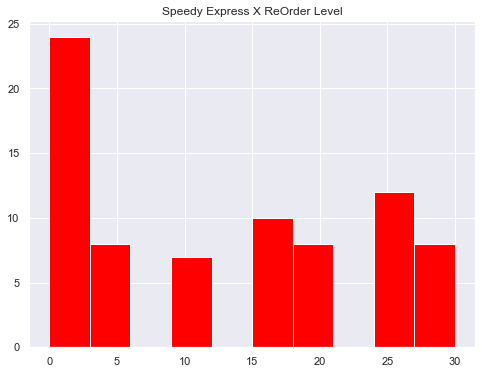

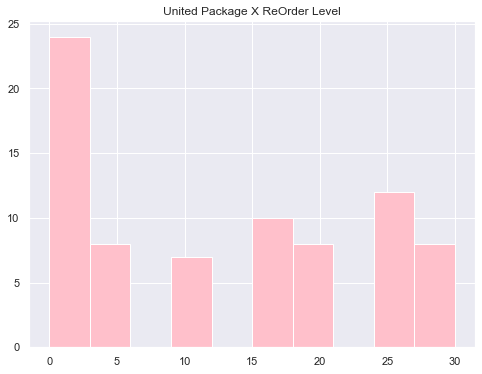

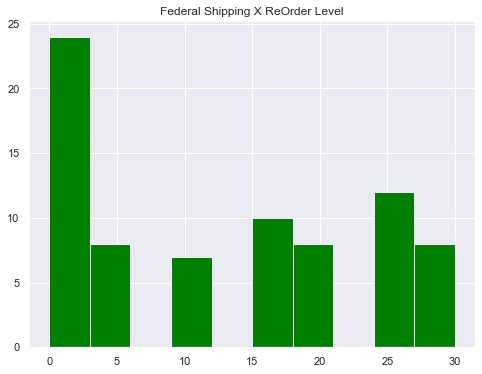

In [52]:
#creating histograms for each company
speedy.hist(figsize=(8,6), color ='red') #speedy will be red
plt.title('Speedy Express X ReOrder Level')
plt.show()
united.hist(figsize=(8,6), color ='pink') #united is pink
plt.title('United Package X ReOrder Level')
plt.show()
federal.hist(figsize=(8,6), color = 'green') #federal is green
plt.title('Federal Shipping X ReOrder Level')
plt.show()


In [53]:
data_Q4.CompanyName.value_counts() #let's see how if one shipping company is used more than another

Federal Shipping    2155
Speedy Express      2155
United Package      2155
Name: CompanyName, dtype: int64

Hmm. That's funny. It looks like each shipping company has been used the exact number of times and has almost the exactly same reorder levels. I have a feeling there will be no difference between the means of re-order level in each company, but let's run our ANOVA to be sure.

 $H_0$: There is no difference in the average re-order levels between shipping companies.
 
 $H_a$: There is a difference in the average re-order levels between shipping companies.

In [54]:
formula = 'ReorderLevel ~ C(CompanyName)' #running our ANOVA
model = ols(formula, data_Q4).fit()
table = sm.stats.anova_lm(model, typ=2)
alpha = 0.05
p = model.f_pvalue

if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


The null hypothesis cannot be rejected


We fail to reject the null hypothesis, meaning that there is no difference in the means of reorder levels between shipping companies. 

## Conclusions

We discovered a lot of solid information for NorthWind. Our results were as follows:

**Q1a: Discounted orders have higher average quantities that non-discounted orders.                                              
Q1b: There is no difference in average quantity of orders across discount levels.**

Take-away: It does not matter whether the discount is 5% off or 25% off, the important thing is the existance of a discount at all.


**Q2a: When customers are living in the same region as the employee responsible for their order, they will on average spend more money on their order.                                                                                                                   
Q2b: Living in a common region with an employee does not have an effect on the average quantity of a customer's order.**

Take-away: Trying to connect employees and consumers who are located in the same area may help employees upsell customers on certain products, but it will not aid an employee in being able to sell larger amounts of a product.

**Q3a: Products that reference a "chef" (such as "Sir Rodney's Marmalade") in their name do not differ in average quantity per order versus their non-chef-referencing product name counterparts.                                                                                                                         
Q3b: Products that reference a chef in their name are on average more expensive that products without a chef in their name.**

Take-away: Referencing a chef in a product name does not increase demand for the product. However, a chef-inspired name may help a consumer justify spending more money on the product.

**Q4: The Shipping company used to deliver an order has no effect on the reorder levels of a product.**

Take-away: The shipping companies had no difference in performance, so if one company is difficult to work with or increases their prices, they can be easily replaced by one of the other two shipping companies.


## Further Exploration

With so much information in the NorthWind database, there are seemingly endless trends to uncover that can help NorthWind run their business as efficiently as possible. In the future, I think that it would be intriguing to explore the database further. I am particularly interested in customer satisfaction with products because I think that in the age of social media, word of mouth travels fast, and if people like a product, that opinion (or product) will most likely end up on a social media platform of theirs, which is essentially free advertising for NorthWind.

Additionally, I would like to look more into customer demographics for specific products, for instance, are consumers from a certain country more likely to buy certain products? Does gender or age of a consumer influence their purchasing habits? I believe customer demographics are informative because targeting your consumer base has proven to be highly effective in increasing revenue for a company.

Employee data is also important for research purposes. I think that taking a closer look at which employees are the most effective at their job could yield some interesting information. For example, are employees who have been at NorthWind for a long time better at customer service? Is there a difference between the performance of employees who are younger versus employess that are older and perhaps have more experience? 